In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

import _pickle as cPickle
import matplotlib as mpl

In [2]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [3]:
cat = np.genfromtxt('hercXY.dat',names=True)

In [4]:
x = cat['X']
y = cat['Y']

In [5]:
xgood = x
ygood = y

In [6]:
x0 = 1.2793787463139303 
y0 = -2.6330748750413733

In [7]:
# herc_x0 = x0
# herc_y0 = y0

# herc_nstar = 4000
# herc_ext = 6.27/60 # degrees
# herc_ext_pix = herc_ext*(3600/0.2255)
# herc_ell = 0.67
# herc_pa = -72.59

# r_h = herc_ext_pix

In [8]:
samples_h = cPickle.load( open( "hercMcmcPL2502-4.p", "rb" ) )
#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich_h,[rich_min,rich_max] = median_interval(samples_h[:,0])
x_h,[xmin,xmax] = median_interval(samples_h[:,1])
y_h,[ymin,ymax] = median_interval(samples_h[:,2])
herc_ext_fit_h,[herc_ext_min,herc_ext_max] = median_interval(samples_h[:,3])
herc_ell_fit_h,[herc_ell_min,herc_ell_max] = median_interval(samples_h[:,4])
herc_pa_fit_h,[herc_pa_min,herc_pa_max] = median_interval(samples_h[:,5])

res = [rich_h,rich_max-rich_h,rich_h-rich_min,x_h,xmax-x_h,x_h-xmin,y_h,ymax-y_h,y_h-ymin,
           herc_ext_fit_h,herc_ext_max-herc_ext_fit_h,herc_ext_fit_h-herc_ext_min,
           herc_ell_fit_h,herc_ell_max-herc_ell_fit_h,herc_ell_fit_h-herc_ell_min,
           herc_pa_fit_h,herc_pa_max-herc_pa_fit_h,herc_pa_fit_h-herc_pa_min]

print(res)

[3917.137541281157, 131.90304276353072, 124.03120039044734, -140.80801049420154, 33.756593168227056, 34.4939870659332, 10.52507957385738, 19.587829047904247, 19.577336465842283, 1793.5315887902316, 83.34063323403211, 76.0536398697127, 0.3347434651657925, 0.03245662848156988, 0.03325373386064662, -84.85682749043671, 2.6207936047709666, 2.559435948302749]


In [9]:
richness = rich_h
gal_ext_pix = herc_ext_fit_h

gal_ell = herc_ell_fit_h
gal_pa = herc_pa_fit_h

herc_x0 = x_h
herc_y0 = y_h

r_h = gal_ext_pix

In [10]:
xbin0 = np.ones((109,1))  # (fltarr(267)+1)
xbin1 = np.ones((1,109))  
xbin1[0] = np.arange(0,109,1)
xbin2 = xbin1 * 30 + 15  # (findgen(267)*30. + 15)
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

# creating x and y arrays to represent the bins across the image

In [11]:
def returnPDF(gal_ell_):
    costh = np.cos(-1 * np.deg2rad(gal_pa))
    sinth = np.sin(-1 * np.deg2rad(gal_pa))

    dx = xbin - x0
    dy = ybin - y0

    r1 = (dx * costh - dy * sinth) / (1 - gal_ell_)
    r2 = (dx * sinth + dy * costh)

    radius = np.sqrt(r1**2 + r2**2)
    
    r_h = gal_ext_pix
    norm = r_h**2 / (np.pi * (1-gal_ell_))
    # half light radius squared / (pi * 1-ell)
    pdf = norm/((radius**2 + r_h**2)**2)
    
    arr = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    r_annuli = (arr + 0.05) * r_h

    # .05r_h, .15r_h
    area_annuli = np.pi * ( (r_annuli + (0.05*r_h))**2 - (r_annuli - (0.05*r_h))**2) * (1-gal_ell_)
    
    pix_per_arcsec=20
    area_arcmin = area_annuli/(pix_per_arcsec*60)**2
    
    aa = area_arcmin
    
    return pdf, radius, aa

In [12]:
pdf0, radius0, aa0 = returnPDF(0)
pdf30, radius30, aa30 = returnPDF(0.3)
pdf60, radius60, aa60 = returnPDF(0.6)
pdf90, radius90, aa90 = returnPDF(0.9)

In [13]:
xdel = 30.
ydel = 30.
pixarea = xdel*ydel  # pixel area in each bin

In [14]:
model_counts_gal0 = richness*pdf0*pixarea  # a 179x179 array
model_counts_gal30 = richness*pdf30*pixarea  # a 179x179 array
model_counts_gal60 = richness*pdf60*pixarea  # a 179x179 array
model_counts_gal90 = richness*pdf90*pixarea  # a 179x179 array

In [15]:
# Observed surface density map
binned_surface_density_30 = np.zeros((109,109))
for ii in range(109):
    for jj in range(109):
        idxgood = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idxgood)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [16]:
# Define annuli
radius1_0=radius0.flatten()
r1_0 = np.where(radius1_0 < (0.1 * r_h))[0]
r2_0 = np.where((radius1_0 < (0.2 * r_h)) & (radius1_0 >= (0.1 * r_h)))[0]
r3_0 = np.where((radius1_0 < (0.3 * r_h)) & (radius1_0 >= (0.2 * r_h)))[0]
r4_0 = np.where((radius1_0 < (0.4 * r_h)) & (radius1_0 >= (0.3 * r_h)))[0]
r5_0 = np.where((radius1_0 < (0.5 * r_h)) & (radius1_0 >= (0.4 * r_h)))[0]
r6_0 = np.where((radius1_0 < (0.6 * r_h)) & (radius1_0 >= (0.5 * r_h)))[0]
r7_0 = np.where((radius1_0 < (0.7 * r_h)) & (radius1_0 >= (0.6 * r_h)))[0]
r8_0 = np.where((radius1_0 < (0.8 * r_h)) & (radius1_0 >= (0.7 * r_h)))[0]
r9_0 = np.where((radius1_0 < (0.9 * r_h)) & (radius1_0 >= (0.8 * r_h)))[0]
r10_0 = np.where((radius1_0 < r_h) & (radius1_0 >= (0.9 * r_h)))[0]

In [17]:
# Define annuli
radius1_30=radius30.flatten()
r1_30 = np.where(radius1_30 < (0.1 * r_h))[0]
r2_30 = np.where((radius1_30 < (0.2 * r_h)) & (radius1_30 >= (0.1 * r_h)))[0]
r3_30 = np.where((radius1_30 < (0.3 * r_h)) & (radius1_30 >= (0.2 * r_h)))[0]
r4_30 = np.where((radius1_30 < (0.4 * r_h)) & (radius1_30 >= (0.3 * r_h)))[0]
r5_30 = np.where((radius1_30 < (0.5 * r_h)) & (radius1_30 >= (0.4 * r_h)))[0]
r6_30 = np.where((radius1_30 < (0.6 * r_h)) & (radius1_30 >= (0.5 * r_h)))[0]
r7_30 = np.where((radius1_30 < (0.7 * r_h)) & (radius1_30 >= (0.6 * r_h)))[0]
r8_30 = np.where((radius1_30 < (0.8 * r_h)) & (radius1_30 >= (0.7 * r_h)))[0]
r9_30 = np.where((radius1_30 < (0.9 * r_h)) & (radius1_30 >= (0.8 * r_h)))[0]
r10_30 = np.where((radius1_30 < r_h) & (radius1_30 >= (0.9 * r_h)))[0]

In [18]:
# Define annuli
radius1_60=radius60.flatten()
r1_60 = np.where(radius1_60 < (0.1 * r_h))[0]
r2_60 = np.where((radius1_60 < (0.2 * r_h)) & (radius1_60 >= (0.1 * r_h)))[0]
r3_60 = np.where((radius1_60 < (0.3 * r_h)) & (radius1_60 >= (0.2 * r_h)))[0]
r4_60 = np.where((radius1_60 < (0.4 * r_h)) & (radius1_60 >= (0.3 * r_h)))[0]
r5_60 = np.where((radius1_60 < (0.5 * r_h)) & (radius1_60 >= (0.4 * r_h)))[0]
r6_60 = np.where((radius1_60 < (0.6 * r_h)) & (radius1_60 >= (0.5 * r_h)))[0]
r7_60 = np.where((radius1_60 < (0.7 * r_h)) & (radius1_60 >= (0.6 * r_h)))[0]
r8_60 = np.where((radius1_60 < (0.8 * r_h)) & (radius1_60 >= (0.7 * r_h)))[0]
r9_60 = np.where((radius1_60 < (0.9 * r_h)) & (radius1_60 >= (0.8 * r_h)))[0]
r10_60 = np.where((radius1_60 < r_h) & (radius1_60 >= (0.9 * r_h)))[0]

In [19]:
# Define annuli
radius1_90=radius90.flatten()
r1_90 = np.where(radius1_90 < (0.1 * r_h))[0]
r2_90 = np.where((radius1_90 < (0.2 * r_h)) & (radius1_90 >= (0.1 * r_h)))[0]
r3_90 = np.where((radius1_90 < (0.3 * r_h)) & (radius1_90 >= (0.2 * r_h)))[0]
r4_90 = np.where((radius1_90 < (0.4 * r_h)) & (radius1_90 >= (0.3 * r_h)))[0]
r5_90 = np.where((radius1_90 < (0.5 * r_h)) & (radius1_90 >= (0.4 * r_h)))[0]
r6_90 = np.where((radius1_90 < (0.6 * r_h)) & (radius1_90 >= (0.5 * r_h)))[0]
r7_90 = np.where((radius1_90 < (0.7 * r_h)) & (radius1_90 >= (0.6 * r_h)))[0]
r8_90 = np.where((radius1_90 < (0.8 * r_h)) & (radius1_90 >= (0.7 * r_h)))[0]
r9_90 = np.where((radius1_90 < (0.9 * r_h)) & (radius1_90 >= (0.8 * r_h)))[0]
r10_90 = np.where((radius1_90 < r_h) & (radius1_90 >= (0.9 * r_h)))[0]

In [20]:
dist_x = np.array([r_h*0.1,r_h*0.2,r_h*0.3,r_h*0.4,r_h*0.5,r_h*0.6,r_h*0.7,r_h*0.8,r_h*0.9,r_h])/1200

In [21]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_galf0 = model_counts_gal0.flatten()
model_counts_galf30 = model_counts_gal30.flatten()
model_counts_galf60 = model_counts_gal60.flatten()
model_counts_galf90 = model_counts_gal90.flatten()
# model_counts_expf = model_counts_exp.flatten()
data_1d0 = [binned_surface_density_30f[r1_0].sum()/aa0[0],
           binned_surface_density_30f[r2_0].sum()/aa0[1],
           binned_surface_density_30f[r3_0].sum()/aa0[2],
           binned_surface_density_30f[r4_0].sum()/aa0[3],
           binned_surface_density_30f[r5_0].sum()/aa0[4],
           binned_surface_density_30f[r6_0].sum()/aa0[5],
           binned_surface_density_30f[r7_0].sum()/aa0[6],
           binned_surface_density_30f[r8_0].sum()/aa0[7],
           binned_surface_density_30f[r9_0].sum()/aa0[8],
           binned_surface_density_30f[r10_0].sum()/aa0[9]]

data_1d30 = [binned_surface_density_30f[r1_30].sum()/aa30[0],
           binned_surface_density_30f[r2_30].sum()/aa30[1],
           binned_surface_density_30f[r3_30].sum()/aa30[2],
           binned_surface_density_30f[r4_30].sum()/aa30[3],
           binned_surface_density_30f[r5_30].sum()/aa30[4],
           binned_surface_density_30f[r6_30].sum()/aa30[5],
           binned_surface_density_30f[r7_30].sum()/aa30[6],
           binned_surface_density_30f[r8_30].sum()/aa30[7],
           binned_surface_density_30f[r9_30].sum()/aa30[8],
           binned_surface_density_30f[r10_30].sum()/aa30[9]]

data_1d60 = [binned_surface_density_30f[r1_60].sum()/aa60[0],
           binned_surface_density_30f[r2_60].sum()/aa60[1],
           binned_surface_density_30f[r3_60].sum()/aa60[2],
           binned_surface_density_30f[r4_60].sum()/aa60[3],
           binned_surface_density_30f[r5_60].sum()/aa60[4],
           binned_surface_density_30f[r6_60].sum()/aa60[5],
           binned_surface_density_30f[r7_60].sum()/aa60[6],
           binned_surface_density_30f[r8_60].sum()/aa60[7],
           binned_surface_density_30f[r9_60].sum()/aa60[8],
           binned_surface_density_30f[r10_60].sum()/aa60[9]]

data_1d90 = [binned_surface_density_30f[r1_90].sum()/aa90[0],
           binned_surface_density_30f[r2_90].sum()/aa90[1],
           binned_surface_density_30f[r3_90].sum()/aa90[2],
           binned_surface_density_30f[r4_90].sum()/aa90[3],
           binned_surface_density_30f[r5_90].sum()/aa90[4],
           binned_surface_density_30f[r6_90].sum()/aa90[5],
           binned_surface_density_30f[r7_90].sum()/aa90[6],
           binned_surface_density_30f[r8_90].sum()/aa90[7],
           binned_surface_density_30f[r9_90].sum()/aa90[8],
           binned_surface_density_30f[r10_90].sum()/aa90[9]]

model_1d0 = [model_counts_galf0[r1_0].sum()/aa0[0],
            model_counts_galf0[r2_0].sum()/aa0[1],
            model_counts_galf0[r3_0].sum()/aa0[2],
            model_counts_galf0[r4_0].sum()/aa0[3],
            model_counts_galf0[r5_0].sum()/aa0[4],
            model_counts_galf0[r6_0].sum()/aa0[5],
            model_counts_galf0[r7_0].sum()/aa0[6],
            model_counts_galf0[r8_0].sum()/aa0[7],
            model_counts_galf0[r9_0].sum()/aa0[8],
            model_counts_galf0[r10_0].sum()/aa0[9]]

In [22]:
model_1d30 = [model_counts_galf30[r1_30].sum()/aa30[0],
            model_counts_galf30[r2_30].sum()/aa30[1],
            model_counts_galf30[r3_30].sum()/aa30[2],
            model_counts_galf30[r4_30].sum()/aa30[3],
            model_counts_galf30[r5_30].sum()/aa30[4],
            model_counts_galf30[r6_30].sum()/aa30[5],
            model_counts_galf30[r7_30].sum()/aa30[6],
            model_counts_galf30[r8_30].sum()/aa30[7],
            model_counts_galf30[r9_30].sum()/aa30[8],
            model_counts_galf30[r10_30].sum()/aa30[9]]

model_1d60 = [model_counts_galf60[r1_60].sum()/aa60[0],
            model_counts_galf60[r2_60].sum()/aa60[1],
            model_counts_galf60[r3_60].sum()/aa60[2],
            model_counts_galf60[r4_60].sum()/aa60[3],
            model_counts_galf60[r5_60].sum()/aa60[4],
            model_counts_galf60[r6_60].sum()/aa60[5],
            model_counts_galf60[r7_60].sum()/aa60[6],
            model_counts_galf60[r8_60].sum()/aa60[7],
            model_counts_galf60[r9_60].sum()/aa60[8],
            model_counts_galf60[r10_60].sum()/aa60[9]]

model_1d90 = [model_counts_galf90[r1_90].sum()/aa90[0],
            model_counts_galf90[r2_90].sum()/aa90[1],
            model_counts_galf90[r3_90].sum()/aa90[2],
            model_counts_galf90[r4_90].sum()/aa90[3],
            model_counts_galf90[r5_90].sum()/aa90[4],
            model_counts_galf90[r6_90].sum()/aa90[5],
            model_counts_galf90[r7_90].sum()/aa90[6],
            model_counts_galf90[r8_90].sum()/aa90[7],
            model_counts_galf90[r9_90].sum()/aa90[8],
            model_counts_galf90[r10_90].sum()/aa90[9]]

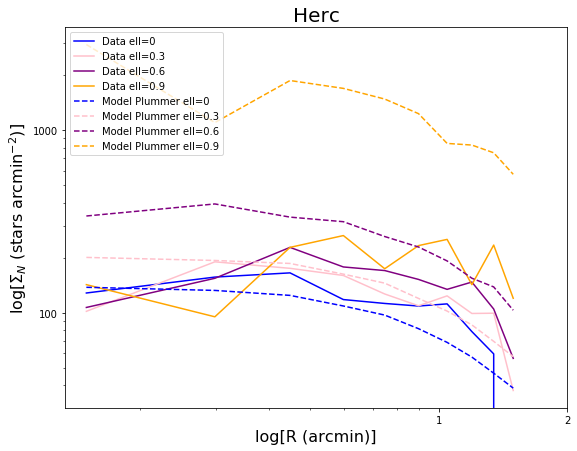

In [23]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(dist_x,data_1d0,label='Data ell=0',color='blue')
ax.plot(dist_x,data_1d30,label='Data ell=0.3',color='pink')
ax.plot(dist_x,data_1d60,label='Data ell=0.6',color='purple')
ax.plot(dist_x,data_1d90,label='Data ell=0.9',color='orange')
ax.plot(dist_x,model_1d0,label='Model Plummer ell=0',color='blue',linestyle='--')
ax.plot(dist_x,model_1d30,label='Model Plummer ell=0.3',color='pink',linestyle='--')
ax.plot(dist_x,model_1d60,label='Model Plummer ell=0.6',color='purple',linestyle='--')
ax.plot(dist_x,model_1d90,label='Model Plummer ell=0.9',color='orange',linestyle='--')

# ax.plot(dist_x,model_1de,label='Model Exp')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-2}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Herc',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yticks([1e+2, 1e+3])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend()
# plt.savefig('figures/sgr2_2202ell.png')
plt.show()

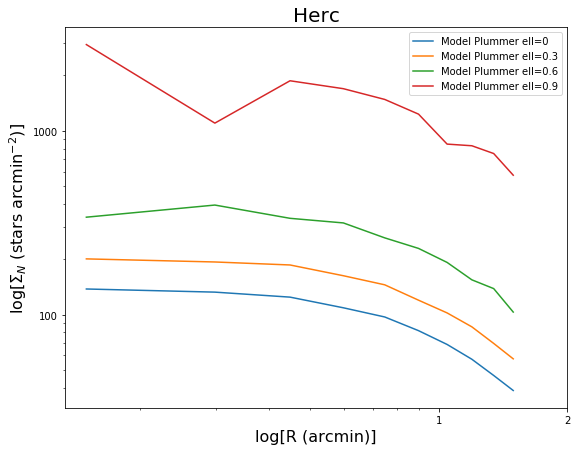

In [24]:
fig, ax = plt.subplots(figsize=(9,7))

# ax.plot(dist_x,data_1d0,label='Data ell=0')
# ax.plot(dist_x,data_1d30,label='Data ell=0.3')
# ax.plot(dist_x,data_1d60,label='Data ell=0.6')
# ax.plot(dist_x,data_1d90,label='Data ell=0.9')
ax.plot(dist_x,model_1d0,label='Model Plummer ell=0')
ax.plot(dist_x,model_1d30,label='Model Plummer ell=0.3')
ax.plot(dist_x,model_1d60,label='Model Plummer ell=0.6')
ax.plot(dist_x,model_1d90,label='Model Plummer ell=0.9')

# ax.plot(dist_x,model_1de,label='Model Exp')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-2}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Herc',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yticks([1e+2, 1e+3])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend()
# plt.savefig('figures/sgr2_1802ellM.png')
plt.show()